# Scraping Craigslist to get House Prices in LA

## Web Scraping

In [2]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get('https://losangeles.craigslist.org/search/apa?hasPic=1&min_bedrooms=2&availabilityMode=0&sale_date=all+dates') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [3]:
#grab the first post
post_one = posts[0]

#If we want, we can print the entire scraped text for the first post
#print(post_one.prettify())

#grab the price of the first post
post_one_price = post_one.a.text
post_one_price.strip()

'$4,399'

In [4]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']
post_one_datetime

'2022-01-08 10:56'

In [5]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [6]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [7]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_bed_sqft_info = post_one.find('span', class_ = 'housing').text.split()

post_one_num_bedrooms = post_one_bed_sqft_info[0]

if len(post_one_bed_sqft_info) > 2:
    post_one_s = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end


post_one_hood = posts[0].find('span', class_='result-hood').text #grabs the neighborhood, this is the problem column that requires
#a lot of cleaning and figuring out later.

In [191]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    url_to_query = "https://losangeles.craigslist.org/search/apa?" + "s=" + str(page) + "&hasPic=1" + "&min_bedrooms=2" + "&availabilityMode=0"
    print(url_to_query)
                
    response = get(url_to_query)

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            #print(post.a.text.strip())
            post_price = int(post.a.text.strip().replace("$", "").replace(",","")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

https://losangeles.craigslist.org/search/apa?s=0&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 1 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=120&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 2 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=240&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 3 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=360&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 4 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=480&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 5 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=600&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 6 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=720&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 7 scraped successfully!
https://losangeles.craigslist.org/search/apa?s=840&hasPic=1&min_bedrooms=2&availabilityMode=0
Page 8 scraped successfully!
https://losangeles

In [172]:
import pandas as pd

df = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           3120 non-null   object 
 1   neighborhood     3120 non-null   object 
 2   post title       3120 non-null   object 
 3   number bedrooms  3120 non-null   object 
 4   sqft             2106 non-null   float64
 5   URL              3120 non-null   object 
 6   price            3120 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 170.8+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2022-01-08 10:56,(Culver City westside-southbay-310 ),"Trash Pickup, Wheelchair Access, Parking",2,833.0,https://losangeles.craigslist.org/wst/apa/d/cu...,4399
1,2022-01-08 10:55,(Downey long beach / 562 ),"Two Bedroom Two Bath Apartment, Balcony, Renov...",2,920.0,https://losangeles.craigslist.org/lgb/apa/d/do...,2606
2,2022-01-08 10:55,"(Hawthorne, CA westside-southbay-310 )",12704 Truro Ave Unit #C,2,850.0,https://losangeles.craigslist.org/wst/apa/d/ha...,2100
3,2022-01-08 10:53,"(1221 W. 3rd St. , Los Angeles, CA central LA...",You deserve more for 2022!,2,979.0,https://losangeles.craigslist.org/lac/apa/d/lo...,2573
4,2022-01-08 10:52,(Playhouse District san gabriel valley ),Patio Area! W/D in Unit! Hard wood Floors!,2,1103.0,https://losangeles.craigslist.org/sgv/apa/d/pa...,3303
5,2022-01-08 10:52,(Culver City westside-southbay-310 ),"Garbage Disposal, Cable Ready, Parking",2,890.0,https://losangeles.craigslist.org/wst/apa/d/cu...,4099
6,2022-01-08 10:52,( san fernando valley ),"Package Acceptance, Patio/ Balcony, Views",2,1115.0,https://losangeles.craigslist.org/sfv/apa/d/ag...,3606
7,2022-01-08 10:50,(los angeles san gabriel valley ),House for rent available,2,1216.0,https://losangeles.craigslist.org/sgv/apa/d/lo...,1100
8,2022-01-08 10:49,( san fernando valley ),"Carpet, Cable Ready, Quartz Countertops",2,700.0,https://losangeles.craigslist.org/sfv/apa/d/lo...,2240
9,2022-01-08 10:49,"(Los Angeles, DTLA, Korea Town, South Park, S...","*HELLO 2022, HELLO NEW HOME FROM ESSEX!!!",2,1175.0,https://losangeles.craigslist.org/lac/apa/d/lo...,2529


# Data Cleaning & Feature Engineering

In [192]:
# Changing the data type of "posted" to datetime
df['posted'] = pd.to_datetime(df['posted'])
df['number bedrooms'] = df['number bedrooms'].astype('int')

#Dropping duplicates
df = df.drop_duplicates(keep = 'first')

In [193]:
## Creating a feature to check if the house is located in Downtown LA, Culvercity, Hollywood
df.loc[:,'Major_Area'] = 'Others'
df.loc[(df['neighborhood'].str.lower().str.contains('downtown')),'Major_Area'] = 'Downtown'
df.loc[(df['neighborhood'].str.lower().str.contains('culver')),'Major_Area'] = 'Culver'
df.loc[(df['neighborhood'].str.lower().str.contains('hollywood')),'Major_Area'] = 'Hollywood'
df.loc[(df['neighborhood'].str.lower().str.contains('central')),'Major_Area'] = 'Central'

## Creating a feature for price buckets of the house
df.loc[((df['price']>=0) & (df['price']<=1000)),'Price_Bucket'] = '0-1000'
df.loc[((df['price']>1000) & (df['price']<=1500)),'Price_Bucket'] = '1000-1500'
df.loc[((df['price']>1500) & (df['price']<=2000)),'Price_Bucket'] = '1500-2000'
df.loc[((df['price']>2000) & (df['price']<=2500)),'Price_Bucket'] = '2000-2500'
df.loc[((df['price']>2500) & (df['price']<=3000)),'Price_Bucket'] = '2500-3000'
df.loc[((df['price']>3000) & (df['price']<=3500)),'Price_Bucket'] = '3000-3500'
df.loc[((df['price']>3500) & (df['price']<=4000)),'Price_Bucket'] = '3500-4000'
df.loc[((df['price']>4000)),'Price_Bucket'] = 'Above 4000'

## Creating a feature to estimate size of the house with 2_Bedroom_Size & 3_Bedroom_Size
df.loc[((df['sqft']>=0) & (df['sqft']<=750) & (df['number bedrooms']==2)),'Size'] = 'Small'
df.loc[((df['sqft']>750) & (df['sqft']<=1250) & (df['number bedrooms']==2)),'Size'] = 'Medium'
df.loc[((df['sqft']>1250) & (df['number bedrooms']==2)),'Size'] = 'Large'


df.loc[((df['sqft']>=0) & (df['sqft']<=1000) & (df['number bedrooms']==3)),'Size'] = 'Small'
df.loc[((df['sqft']>1000) & (df['sqft']<=1750) & (df['number bedrooms']==3)),'Size'] = 'Medium'
df.loc[((df['sqft']>1750) & (df['number bedrooms']==3)),'Size'] = 'Large'

df.loc[((df['sqft']>=0) & (df['sqft']<=1250) & (df['number bedrooms']==4)),'Size'] = 'Small'
df.loc[((df['sqft']>1250) & (df['sqft']<=2000) & (df['number bedrooms']==4)),'Size'] = 'Medium'
df.loc[((df['sqft']>2000) & (df['number bedrooms']==4)),'Size'] = 'Large'

df.loc[((df['sqft']>=0) & (df['sqft']<=1500) & (df['number bedrooms']==5)),'Size'] = 'Small'
df.loc[((df['sqft']>1500) & (df['sqft']<=2000) & (df['number bedrooms']==5)),'Size'] = 'Medium'
df.loc[((df['sqft']>2500) & (df['number bedrooms']==5)),'Size'] = 'Large'

#print(df['Major_Area'].value_counts())
#print(df['Price_Bucket'].value_counts())
#print(df['Size'].value_counts())

print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   posted           120 non-null    datetime64[ns]
 1   neighborhood     120 non-null    object        
 2   post title       120 non-null    object        
 3   number bedrooms  120 non-null    int32         
 4   sqft             81 non-null     float64       
 5   URL              120 non-null    object        
 6   price            120 non-null    int64         
 7   Major_Area       120 non-null    object        
 8   Price_Bucket     120 non-null    object        
 9   Size             80 non-null     object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(6)
memory usage: 9.8+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price,Major_Area,Price_Bucket,Size
0,2022-01-08 10:56:00,(Culver City westside-southbay-310 ),"Trash Pickup, Wheelchair Access, Parking",2,833.0,https://losangeles.craigslist.org/wst/apa/d/cu...,4399,Culver,Above 4000,Medium
1,2022-01-08 10:55:00,(Downey long beach / 562 ),"Two Bedroom Two Bath Apartment, Balcony, Renov...",2,920.0,https://losangeles.craigslist.org/lgb/apa/d/do...,2606,Others,2500-3000,Medium
2,2022-01-08 10:55:00,"(Hawthorne, CA westside-southbay-310 )",12704 Truro Ave Unit #C,2,850.0,https://losangeles.craigslist.org/wst/apa/d/ha...,2100,Others,2000-2500,Medium
3,2022-01-08 10:53:00,"(1221 W. 3rd St. , Los Angeles, CA central LA...",You deserve more for 2022!,2,979.0,https://losangeles.craigslist.org/lac/apa/d/lo...,2573,Central,2500-3000,Medium
4,2022-01-08 10:52:00,(Playhouse District san gabriel valley ),Patio Area! W/D in Unit! Hard wood Floors!,2,1103.0,https://losangeles.craigslist.org/sgv/apa/d/pa...,3303,Others,3000-3500,Medium
5,2022-01-08 10:52:00,(Culver City westside-southbay-310 ),"Garbage Disposal, Cable Ready, Parking",2,890.0,https://losangeles.craigslist.org/wst/apa/d/cu...,4099,Culver,Above 4000,Medium
6,2022-01-08 10:52:00,( san fernando valley ),"Package Acceptance, Patio/ Balcony, Views",2,1115.0,https://losangeles.craigslist.org/sfv/apa/d/ag...,3606,Others,3500-4000,Medium
7,2022-01-08 10:50:00,(los angeles san gabriel valley ),House for rent available,2,1216.0,https://losangeles.craigslist.org/sgv/apa/d/lo...,1100,Others,1000-1500,Medium
8,2022-01-08 10:49:00,( san fernando valley ),"Carpet, Cable Ready, Quartz Countertops",2,700.0,https://losangeles.craigslist.org/sfv/apa/d/lo...,2240,Others,2000-2500,Small
9,2022-01-08 10:49:00,"(Los Angeles, DTLA, Korea Town, South Park, S...","*HELLO 2022, HELLO NEW HOME FROM ESSEX!!!",2,1175.0,https://losangeles.craigslist.org/lac/apa/d/lo...,2529,Central,2500-3000,Medium


# Exploratory Data Visualizations

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

In [179]:
# Grouping Data with respect to bedrooms and finding counts
pd.set_option('precision',2)
df_grouped_br = pd.DataFrame(df.groupby('number bedrooms').agg('price').count()).reset_index(drop=False).rename({'price':'count'}, axis = 1)
df_grouped_br

,number bedrooms,count
0,2,84
1,3,32
2,4,2
3,5,2


### Finding counts of different bedroom houses

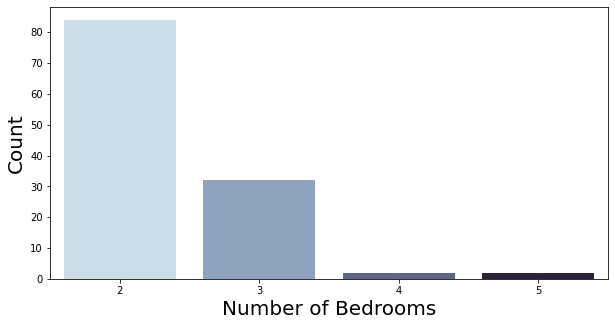

In [180]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x=df_grouped_br['number bedrooms'], y=df_grouped_br['count'], palette = "ch:s=.25,rot=-.25");
ax.set_xlabel('Number of Bedrooms', fontsize = 20);
ax.set_ylabel('Count', fontsize = 20);

### Finding counts of different house sizes

In [194]:
# Grouping Data with respect to size and finding counts
pd.set_option('precision',2)
df_grouped_size = pd.DataFrame(df.groupby('Size').agg('price').count()).reset_index(drop=False).rename({'price':'count'}, axis = 1)
df_grouped_size

,Size,count
0,Large,9
1,Medium,67
2,Small,4


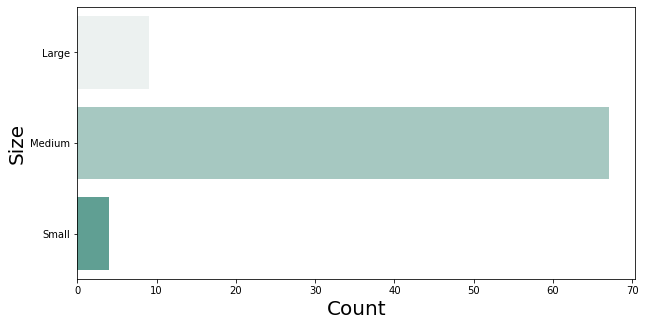

In [195]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x='count', y='Size', data = df_grouped_size, palette = "light:#5A9");
ax.set_xlabel('Count', fontsize = 20);
ax.set_ylabel('Size', fontsize = 20);

### Finding counts of different price buckets

In [196]:
df_grouped_pb = pd.DataFrame(df.groupby('Price_Bucket').agg('price').count()).reset_index(drop=False).rename({'price':'count'}, axis = 1)
df_grouped_pb

,Price_Bucket,count
0,0-1000,5
1,1000-1500,5
2,1500-2000,18
3,2000-2500,20
4,2500-3000,28
5,3000-3500,13
6,3500-4000,15
7,Above 4000,16


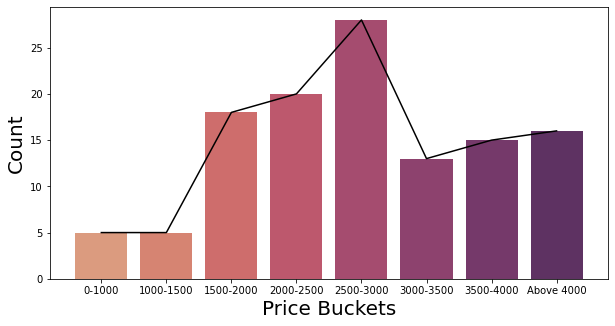

In [197]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x='Price_Bucket', y='count', data = df_grouped_pb , palette = 'flare');
sns.lineplot(x='Price_Bucket', y='count', data = df_grouped_pb, color = 'black');
ax.set_xlabel('Price Buckets', fontsize = 20);
ax.set_ylabel('Count', fontsize = 20);

### Finding distribution of areas (Central, Culver, Holywood, Others) w.r.t house area in sqft

In [198]:
pd.set_option('precision',2)
df_grouped_area_size = df.groupby(['Major_Area']).mean().reset_index()
df_grouped_area_size

,Major_Area,number bedrooms,sqft,price
0,Central,2.35,1151.96,2865.96
1,Culver,2.00,861.50,4249.00
2,Hollywood,2.22,1212.50,2395.56
3,Others,2.37,1155.39,2857.95


In [199]:
df[(df['neighborhood'].str.lower().str.contains('culver'))].nlargest(100,'price')

,posted,neighborhood,post title,number bedrooms,sqft,URL,price,Major_Area,Price_Bucket,Size
0,2022-01-08 10:56:00,(Culver City westside-southbay-310 ),"Trash Pickup, Wheelchair Access, Parking",2,833.0,https://losangeles.craigslist.org/wst/apa/d/cu...,4399,Culver,Above 4000,Medium
5,2022-01-08 10:52:00,(Culver City westside-southbay-310 ),"Garbage Disposal, Cable Ready, Parking",2,890.0,https://losangeles.craigslist.org/wst/apa/d/cu...,4099,Culver,Above 4000,Medium


In [213]:
df_grouped_area_size["sqft"] = round(df_grouped_area_size.sqft,2)
df_grouped_area_size

,Major_Area,number bedrooms,sqft,price
0,Central,2.35,1151.96,2865.96
1,Culver,2.00,861.50,4249.00
2,Hollywood,2.22,1212.50,2395.56
3,Others,2.37,1155.39,2857.95


Text(0, 0.5, 'Price')

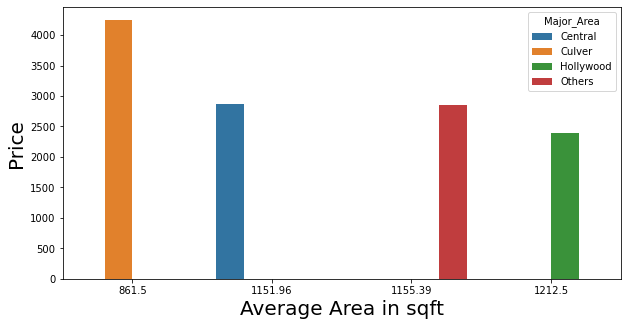

In [212]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = df_grouped_area_size, x = "sqft", y = 'price', hue = 'Major_Area');
ax.set_xlabel("Average Area in sqft", fontsize = 20)
ax.set_ylabel("Price", fontsize = 20)